In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [15]:
data = pd.read_csv("D:\\ds\\WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
def get_uniques(dataframe):
    columns = dataframe.columns
    uniques = [dataframe[col].dropna().unique().tolist() for col in columns]
    data_types = [dataframe[col].dtype for col in columns]
    result_df = pd.DataFrame(
        {'Столбцы': columns,
         'Уникальные значения': uniques, 
         'Тип данных': data_types})
    return result_df

In [8]:
get_uniques(data)

,Столбцы,Уникальные значения,Тип данных
0,customerID,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",object
1,gender,"[Female, Male]",object
2,SeniorCitizen,"[0, 1]",int64
3,Partner,"[Yes, No]",object
4,Dependents,"[No, Yes]",object
5,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",int64
6,PhoneService,"[No, Yes]",object
7,MultipleLines,"[No phone service, No, Yes]",object
8,InternetService,"[DSL, Fiber optic, No]",object
9,OnlineSecurity,"[No, Yes, No internet service]",object


In [16]:
data = data.drop('customerID', axis=1)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)

X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=1
)
numeric_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
X_train[numeric_cols] = X_train[numeric_cols].fillna(0)
X_test[numeric_cols] = X_test[numeric_cols].fillna(0)

Преобразуйте бинарные признаки через OrdinalEncoder, а категориальные - через OneHotEncoder (с параметром sparse_output=False).

Не забудьте удалить преобразованные категориальные колонки из выборок.

Какая получилась размерность у тренировочной и тестовой выборок?

In [ ]:
binary_cols = [
    'gender',          
    'Partner',         
    'Dependents',      
    'PhoneService',    
    'PaperlessBilling' 
]
categorical_cols = [
    'MultipleLines',       
    'InternetService',     
    'OnlineSecurity',      
    'OnlineBackup',        
    'DeviceProtection',    
    'TechSupport',        
    'StreamingTV',        
    'StreamingMovies',    
    'Contract',           
    'PaymentMethod'       
]
ordinal_encoder = OrdinalEncoder()
X_train[binary_cols] = ordinal_encoder.fit_transform(X_train[binary_cols])
X_test[binary_cols] = ordinal_encoder.transform(X_test[binary_cols])

onehot_encoder = OneHotEncoder(sparse_output=False)  # Без drop='first'
X_train_cat_encoded = onehot_encoder.fit_transform(X_train[categorical_cols])
X_test_cat_encoded = onehot_encoder.transform(X_test[categorical_cols])

encoded_cat_cols = onehot_encoder.get_feature_names_out(categorical_cols)
X_train_encoded = pd.DataFrame(X_train_cat_encoded, columns=encoded_cat_cols, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_cat_encoded, columns=encoded_cat_cols, index=X_test.index)
X_train_final = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(categorical_cols, axis=1), X_test_encoded], axis=1)

print("Размерность тренировочной выборки:", X_train_final.shape)
print("Размерность тестовой выборки:", X_test_final.shape)

Размерность тренировочной выборки: (5634, 40)
Размерность тестовой выборки: (1409, 40)


Обучите случайный лес на базовых гиперпараметрах с фиксированным random_state=1 и посчитайте метрику f1 с усреднением macro на тренировочной и тестовой выборках.

Обучите градиентный бустинг из sklearn на базовых гиперпараметрах с фиксированным random_state=1 и посчитайте метрику f1 с усреднением macro на тренировочной и тестовой выборках.

Укажите, на сколько метрика на тесте на градиентном бустинге лучше, чем на случайном лесу, округлив до второго знака после точки.

In [19]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_final, y_train)
y_train_pred_rf = rf.predict(X_train_final)
y_test_pred_rf = rf.predict(X_test_final)
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='macro')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print("Random Forest:")
print(f"F1 (train, macro): {f1_train_rf:.4f}")
print(f"F1 (test, macro): {f1_test_rf:.4f}")

Random Forest:
F1 (train, macro): 0.9970
F1 (test, macro): 0.6999


In [ ]:
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_final, y_train)

y_train_pred_gb = gb.predict(X_train_final)
y_test_pred_gb = gb.predict(X_test_final)
f1_train_gb = f1_score(y_train, y_train_pred_gb, average='macro')
f1_test_gb = f1_score(y_test, y_test_pred_gb, average='macro')

print("\nGradient Boosting:")
print(f"F1 (train, macro): {f1_train_gb:.4f}")
print(f"F1 (test, macro): {f1_test_gb:.4f}")


Gradient Boosting:
F1 (train, macro): 0.7592
F1 (test, macro): 0.7316


In [21]:
improvement = f1_test_gb - f1_test_rf
print(f"\nУлучшение F1 (тест, macro): {improvement:.2f}")


Улучшение F1 (тест, macro): 0.03


У модели градиентный бустинг оставьте параметр random_state=1. Измените глубину деревьев от 1 до 20 с шагом 1.

Визуализируйте изменение метрики f1 macro на тренировочной и тестовой выборках от параметра глубины.

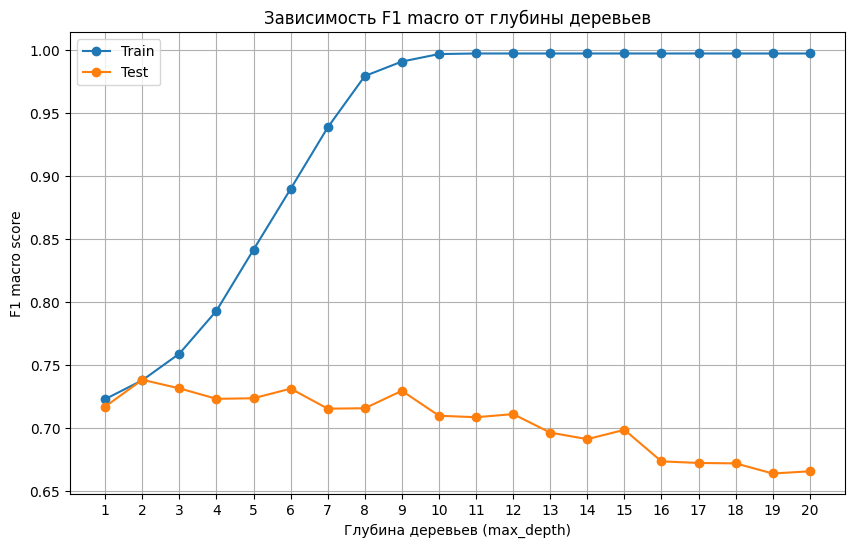

In [23]:
train_scores = []
test_scores = []
depths = range(1, 21)

for depth in depths:
    gb = GradientBoostingClassifier(max_depth=depth, random_state=1)
    gb.fit(X_train_final, y_train)
    y_train_pred = gb.predict(X_train_final)
    y_test_pred = gb.predict(X_test_final)
    train_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_scores.append(f1_score(y_test, y_test_pred, average='macro'))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'o-', label='Train')
plt.plot(depths, test_scores, 'o-', label='Test')
plt.xlabel('Глубина деревьев (max_depth)')
plt.ylabel('F1 macro score')
plt.title('Зависимость F1 macro от глубины деревьев')
plt.xticks(depths)
plt.grid(True)
plt.legend()
plt.show()

У модели градиентный бустинг оставьте параметр random_state=1. Измените скорость обучения от 0.1 до 0.9 с шагом 0.1.

Визуализируйте изменение метрики f1 macro на тренировочной и тестовой выборках от параметра скорости обучения.

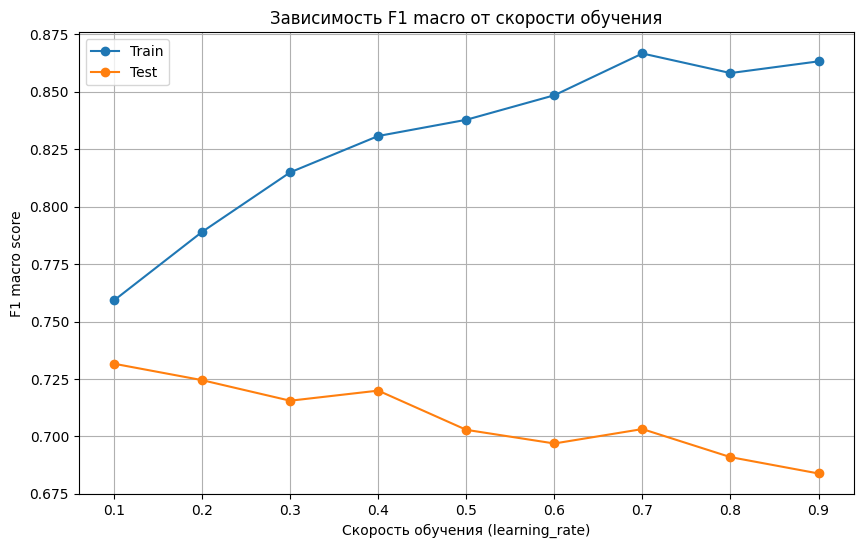

Оптимальная скорость обучения: 0.1
Лучший F1 на тесте: 0.7316


In [ ]:
train_scores = []
test_scores = []
learning_rates = np.arange(0.1, 1.0, 0.1) 

for lr in learning_rates:
    gb = GradientBoostingClassifier(learning_rate=lr, random_state=1)
    gb.fit(X_train_final, y_train)
    y_train_pred = gb.predict(X_train_final)
    y_test_pred = gb.predict(X_test_final)
    train_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_scores.append(f1_score(y_test, y_test_pred, average='macro'))

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, 'o-', label='Train')
plt.plot(learning_rates, test_scores, 'o-', label='Test')
plt.xlabel('Скорость обучения (learning_rate)')
plt.ylabel('F1 macro score')
plt.title('Зависимость F1 macro от скорости обучения')
plt.xticks(learning_rates)
plt.grid(True)
plt.legend()
plt.show()

best_lr = learning_rates[np.argmax(test_scores)]
print(f"Оптимальная скорость обучения: {best_lr:.1f}")
print(f"Лучший F1 на тесте: {max(test_scores):.4f}")

Обучите модель CatBoost с параметрами random_state=1, n_estimators=100 на данных без не явных пропусков, без идентификатора клиента и без предобработанных категориальных и бинарных переменных, передав в параметр cat_features модели список категориальных и бинарных признаков.

Укажите метрику F1 macro на тестовой выборке, округлив ее до третьего знака после точки.

In [29]:
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

# Список всех категориальных признаков (включая бинарные)
cat_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Преобразуем ВСЕ категориальные признаки в строковый тип
for col in cat_features:
    X_train_fixed[col] = X_train_fixed[col].astype(str)
    X_test_fixed[col] = X_test_fixed[col].astype(str)

# Убедимся, что в числовых признаках нет пропусков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train_fixed[numeric_cols] = X_train_fixed[numeric_cols].fillna(0)
X_test_fixed[numeric_cols] = X_test_fixed[numeric_cols].fillna(0)

# Инициализация модели
model = CatBoostClassifier(
    random_state=1,
    n_estimators=100,
    cat_features=cat_features,
    verbose=0
)

# Обучение модели
model.fit(X_train_fixed, y_train)

# Предсказание и оценка
y_pred = model.predict(X_test_fixed)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 macro (test): {f1:.3f}")

F1 macro (test): 0.732


В этом задании будем делать свой градиентный бустинг.

Нужно сделать класс с методами:

_ _init_ _ - на вход передаются параметры n_estimators, learning_rate, max_depth

fit - на вход передаются параметры X, y

predict - на вход передаются параметры X, y

Первое предсказание сделайте, как среднее целевых значений на тренировочной выборке, последующие - предсказания отклонений (y - y_hat). Пользуйтесь деревьями решений для задачи регрессии, фиксируйте у них random_state номером дерева в ансамбле, начиная с 0.

Можете воспользоваться заготовкой.

Обучите получившуюся модель на тренировочной выборке, где обработаны пропуски и категории, сделайте предсказания на тестовой выборке и укажите метрику качества f1 macro, округлив её до третьего знака после точки. Например. 0,111

In [ ]:
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None
        self.le = LabelEncoder()

    def fit(self, X, y):
        y = self.le.fit_transform(y)
        self.base_pred = np.mean(y)
        y_hat = np.full_like(y, self.base_pred, dtype=float)
        residuals = y - y_hat

        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=i)
            tree.fit(X, residuals)
            self.trees.append(tree)
            predictions = tree.predict(X)
            y_hat += self.learning_rate * predictions
            residuals = y - y_hat

    def predict(self, X):
        y_hat = np.full(X.shape[0], self.base_pred)  
        for tree in self.trees:
            y_hat += self.learning_rate * tree.predict(X)
        binary_pred = np.where(y_hat > 0.5, 1, 0)
        return self.le.inverse_transform(binary_pred)

gb = GradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
gb.fit(X_train_final.values, y_train.values)
y_pred = gb.predict(X_test_final.values)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 macro (test): {f1:.3f}")

F1 macro (test): 0.716
